# Fine Food Recommender System
Dataset: Amazon Fine Foods Reviews.

Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

Author: Luis Da Silva.

Description: "This dataset consists of reviews of fine foods from amazon. The data span a period of more than 10 years, including all ~500,000 reviews up to October 2012. Reviews include product and user information, ratings, and a plain text review. It also includes reviews from all other Amazon categories."

Recommendation systems can be built in a variety of ways. If one knows nothing about the given user then one could simply recommend the most popular or hot items, this is a quite straightforward approach but will often fail to be accurate. A better approach -but requires some data about the user/audience- is to employ either collaborative filtering, which recommends content similar to the one the user has shown interest in, or content-based filtering, which shows content that some other users that seem to have alike preferences rated with high score.

In this exercise, I'm implementing a mixture of those two methods by training a Random Forest Regressor to predict the score a user will give to a product s/he hasn't consumed yet. This method is chosen because it is simple enough to be implemented quickly, but complex enough to take advantage of most of the information in the dataset (including text) to produce accurate results.

In [118]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import re
from collections import Counter
from itertools import product
from joblib import dump, load

from scipy.sparse import coo_matrix

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import confusion_matrix, f1_score, mean_squared_error

import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer
from nltk.stem.wordnet import WordNetLemmatizer

In [2]:
def describe(df, var, name):
    n = df[var].nunique()
    m = df[var].value_counts()
    s = df.groupby(var)['Score'].mean()
    print('Number of {}: {}'.format(name, n))
    print('Reviews')
    print('Mean: {:.2f}, std: {:.2f}, max: {}, median: {:.2f}, min: {}'.\
          format(m.mean(), m.std(), m.max(), m.median(), m.min()))
    print('Score')
    print('Mean: {:.2f}, std: {:.2f}, max: {}, median: {:.2f}, min: {}'.\
          format(s.mean(), s.std(), s.max(), s.median(), s.min()))

In [3]:
df = pd.read_csv('Reviews.csv')
print(df.shape)
df.head()

(568454, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [4]:
# Time is not in proper format
df.Time = pd.to_datetime(df.Time, unit='s')
df['Year'] = df.Time.dt.year

# Id is useless
df.drop('Id', axis=1, inplace=True)

# Factorize product and user ids to save memory
df.UserId = df.UserId.factorize()[0]
df.ProductId = df.ProductId.factorize()[0]

In [5]:
# Missing data
df.isnull().sum()

ProductId                  0
UserId                     0
ProfileName               16
HelpfulnessNumerator       0
HelpfulnessDenominator     0
Score                      0
Time                       0
Summary                   27
Text                       0
Year                       0
dtype: int64

In [6]:
# I'm dropping products and users with 10 reviews or less
# I want to avoid memory errors
# And their utility may be marginal
df = df[df.groupby('ProductId')['ProductId'].transform('count') > 10]
df = df[df.groupby('UserId')['UserId'].transform('count') > 10]
df.shape

(95552, 10)

In [7]:
# Have users rated the same product twice or more?
df[['ProductId', 'UserId']].duplicated().sum()

6161

In [8]:
describe(df, 'UserId', 'users')
print('*--'*20)
describe(df, 'ProductId', 'products')

Number of users: 5049
Reviews
Mean: 18.92, std: 13.65, max: 291, median: 14.00, min: 11
Score
Mean: 4.15, std: 0.98, max: 5.0, median: 4.40, min: 1.0
*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--
Number of products: 7883
Reviews
Mean: 12.12, std: 31.71, max: 369, median: 3.00, min: 1
Score
Mean: 4.26, std: 0.84, max: 5.0, median: 4.50, min: 1.0


In [9]:
# I'm planning on getting features from both summary and text
df['Full_txt'] = df['Summary'].fillna('') + ' ' + df['Text']

# Split data into train, test and validation
The aim is to train the model into the train dataset, tune hyper parameter with the test dataset and then perform final validation with the validation dataset. This gives a more accurate perception of the real error because the model never gets to see the answers (scores) for the validation set.

In [10]:
# Split train and validation
sss = StratifiedShuffleSplit(n_splits=2, test_size=0.2, random_state = 412)
for train_idx, test_idx in sss.split(df, df.Score, df.ProductId):
    train = df.iloc[train_idx]
    validation = df.iloc[test_idx]
    break
print(train.shape, validation.shape)

(76441, 11) (19111, 11)


In [11]:
# Now split train in train and test
sss = StratifiedShuffleSplit(n_splits=2, test_size=0.2, random_state = 412)
for train_idx, test_idx in sss.split(train, train.Score, train.ProductId):
    test = train.iloc[test_idx]
    train = train.iloc[train_idx]
    break
print(train.shape, test.shape)

(61152, 11) (15289, 11)


In [12]:
describe(train, 'UserId', 'users')
print('*--'*20)
describe(train, 'ProductId', 'products')
print('*--'*20)
describe(validation, 'UserId', 'users')
print('*--'*20)
describe(validation, 'ProductId', 'products')

Number of users: 5049
Reviews
Mean: 12.11, std: 8.97, max: 198, median: 10.00, min: 2
Score
Mean: 4.14, std: 0.99, max: 5.0, median: 4.40, min: 1.0
*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--
Number of products: 6891
Reviews
Mean: 8.87, std: 21.60, max: 236, median: 2.00, min: 1
Score
Mean: 4.25, std: 0.89, max: 5.0, median: 4.50, min: 1.0
*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--
Number of users: 4842
Reviews
Mean: 3.95, std: 3.22, max: 63, median: 3.00, min: 1
Score
Mean: 4.15, std: 1.07, max: 5.0, median: 4.50, min: 1.0
*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--
Number of products: 4282
Reviews
Mean: 4.46, std: 8.19, max: 76, median: 1.00, min: 1
Score
Mean: 4.26, std: 0.97, max: 5.0, median: 4.60, min: 1.0


# Text keywords extraction
As data has been semi-anonimized, the best description of the product exists in the reviews. By extracting keywords from then, one could obtain useful groups of products. This assumes that, when reviewing, people tend to use certain word when talking about a specific type of product.

A very raw version of keyword extraction is being performed here, with no especial tuning being made. Also, no attempt to get a feeling of the whole text instead of just the keywords is being made.

In [13]:
# I noticed some words I'd like to remove
words = ['br', 'john', 'pb', 'pg', 'ck', 'amazon', 'wayyyy', 'come', 'bye']
stop_words = set(stopwords.words("english"))
stop_words = stop_words.union(words)

In [14]:
def regularize_text(x, stop_words=stop_words):
    # standardize text
    x = re.sub('[^a-zA-Z]', ' ', x)
    x = x.lower()
    
    x=re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",x)
    x=re.sub("(\\d|\\W)+"," ",x)
    
    x = x.split(' ')
    ps=PorterStemmer()
    lem = WordNetLemmatizer()
    x = [lem.lemmatize(word) for word in x if not word in stop_words]
    return ' '.join(x)

In [15]:
# I only use train dataset in this phase to avoid data leakage
train['Full_txt'] = train['Full_txt'].apply(regularize_text)

In [16]:
# Vectorize words
countV=CountVectorizer(max_df=0.8,stop_words=stop_words, max_features=10000, ngram_range=(1,1))
X=countV.fit_transform(train['Full_txt'])

# Calculate TFIDF
tfidf = TfidfTransformer()
tfidf.fit(X)
feature_names=countV.get_feature_names()

In [17]:
# Functions to extract most important keywords
def sort_matrix(m):
    tuples = zip(m.col, m.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)
 
def extract_n(names, items, n=10):
    sorted_items = items[:n+1]
 
    scores = []
    features = []
    
    # word index and corresponding tf-idf score
    for idx, s in sorted_items:
        scores.append(round(s, 3))
        features.append(names[idx])

    return dict(zip(features, scores)) 

def keywords_from_doc(doc, tfidf, n=5):
    tfidf_vector=tfidf.transform(countV.transform(doc))
    sorted_items=sort_matrix(tfidf_vector.tocoo())
    return extract_n(feature_names,sorted_items,n)

In [18]:
# Get dict with the keywords of each product
keywords_per_product = {}
ids = train['ProductId'].unique()
for i in ids:
    mask = train['ProductId'] == i
    doc = train[mask]['Full_txt'].values
    keywords = keywords_from_doc(doc, tfidf, 5)
    keywords_per_product[i] = list(keywords.keys())

In [19]:
# get the frequency of keywords and only keep the most frequent 5%
count = Counter()
for v in keywords_per_product.values():
    count.update(v)
    
perc = np.percentile(list(count.values()), 95)
keywords = [k for k,v in count.items() if v>=perc]

In [20]:
# OneHot encode keywords
prod_vec = {}
for product in train['ProductId'].unique():
    vec = []
    for keyword in keywords:
        if keyword in keywords_per_product[product]:
            vec.append(1)
        else:
            vec.append(0)
    prod_vec[product] = vec
    
prod_features = pd.DataFrame(prod_vec).T
prod_features.columns = keywords
prod_features.head()

,bergamot,chai,earl,grey,food,cat,dog,organic,yorkie,chamomile,...,heat,formula,loved,pancake,toddler,really,recommended,sardine,allergy,kernel
65162,1,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
17957,0,0,0,0,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
17576,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
27285,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
38032,0,0,0,0,0,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0


Keywords per product have been extracted and one-hot encoded. It looks good enough, so I'll just merge it into the train dataset.

In [21]:
train = train.merge(prod_features, left_on=['ProductId'], right_index=True, how='left')

# Get aditional features from scores

In [22]:
def standard_features(data, group, var, prefix):
    g = data.groupby(group)[var]
    data[prefix+var+'Mean'] = g.transform('mean')
    data[prefix+var+'Std'] = g.transform('std')
    data[prefix+var+'Count'] = g.transform('count')
    return data

train = standard_features(train, 'UserId', 'Score', 'User')
train = standard_features(train, 'ProductId', 'Score', 'Product')
train = standard_features(train, ['ProductId', 'Year'], 'Score', 'ProductYear')

# Merge features to train and validation
To avoid data leakage, features are only extracted from train dataset and then merged back into the test and validation set.

In [23]:
product_cols = train.filter(regex='(Product).*').columns
user_cols = train.filter(regex='(User).*').columns

In [24]:
test = test.merge(train[product_cols].groupby('ProductId').mean(), left_on='ProductId', right_index=True, how='left')
test = test.merge(train[user_cols].groupby('UserId').mean(), left_on='UserId', right_index=True, how='left')
test = test.merge(prod_features, left_on=['ProductId'], right_index=True, how='left')

In [25]:
test.fillna(0, inplace=True) # There is no information about NaNs

In [59]:
validation = validation.merge(train[product_cols].groupby('ProductId').mean(), 
                              left_on='ProductId', right_index=True, how='left')
validation = validation.merge(train[user_cols].groupby('UserId').mean(), 
                              left_on='UserId', right_index=True, how='left')
validation = validation.merge(prod_features, left_on=['ProductId'], 
                              right_index=True, how='left')
validation.fillna(0, inplace=True) # There is no information about NaNs

# Train, tune and validate model

In [26]:
def scorer(model, X_train, X_test, y_train, y_test):
    # MSE Scorer
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    return mean_squared_error(y_test, preds)

In [48]:
def grid_search(model, X_train, X_test, y_train, y_test, param_grid, rs=542, verbose=False):
    # Hyperparameter grid search
    if verbose:
        total = sum([1 for _ in product(*param_grid.values())])
    
    combs = product(*param_grid.values())
    best_score = np.inf
    for i, comb in enumerate(combs):            
        params = dict(zip(param_grid.keys(), comb))
        model.set_params(**params)
        score = scorer(model, X_train, X_test, y_train, y_test)
        if score < best_score:
            best_score = score
            best_params = params
            
        if verbose:
            print('Parameter combination: {}/{}. Score:{:.4f}, best:{:.4f}.'.format(i+1,total, score, best_score))
            
    return best_params, best_score

In [28]:
# Split X y
cols = train.drop(['ProfileName', 'HelpfulnessNumerator', 
                   'HelpfulnessDenominator', 'Score', 'Time', 'Year',
                  'Summary', 'Text', 'Full_txt', 'UserId', 'ProductId'],
                  axis=1).columns
X_train = train[cols].fillna(0) #NaNs are in std
y_train = train['Score']
X_test = test[cols].fillna(0)
y_test = test['Score']

In [34]:
# Fit the base regressor
rf = RandomForestRegressor(n_estimators=200, n_jobs=-1, random_state=412)
rf.fit(X_train, y_train)
preds = rf.predict(X_test)
score = mean_squared_error(y_test, preds)
print(score)

1.0209428715876088


In [35]:
# Tune features
best_score = score
features = X_train.columns
fi = rf.feature_importances_
lfi = np.log(fi)
for q in np.arange(0.05, 1, 0.05):
    v = np.exp(np.quantile(lfi, q))
    features = X_train.columns[fi>=v]

    score = scorer(rf, X_train[features], X_test[features], y_train, y_test)
    if score < best_score:
        best_score = score
        best_features = features
        best_q = q
    print('Tested q: {:.2f}, score: {:.4f}. Best score: {:.4f}'.format(q, score, best_score))
    
for q in np.arange(best_q-0.04, best_q+0.04, 0.01):
    if np.isclose(best_q,q):
        continue
    v = np.exp(np.quantile(lfi, q))
    features = X_train.columns[fi>=v]

    score = scorer(rf, X_train[features], X_test[features], y_train, y_test)
    if score < best_score:
        best_score = score
        best_features = features
        best_q = q
    print('Tested q: {:.2f}, score: {:.4f}. Best score: {:.4f}'.format(q, score, best_score))

Tested q: 0.05, score: 1.0206. Best score: 1.0206
Tested q: 0.10, score: 1.0208. Best score: 1.0206
Tested q: 0.15, score: 1.0232. Best score: 1.0206
Tested q: 0.20, score: 1.0204. Best score: 1.0204
Tested q: 0.25, score: 1.0222. Best score: 1.0204
Tested q: 0.30, score: 1.0202. Best score: 1.0202
Tested q: 0.35, score: 1.0203. Best score: 1.0202
Tested q: 0.40, score: 1.0211. Best score: 1.0202
Tested q: 0.45, score: 1.0194. Best score: 1.0194
Tested q: 0.50, score: 1.0205. Best score: 1.0194
Tested q: 0.55, score: 1.0207. Best score: 1.0194
Tested q: 0.60, score: 1.0189. Best score: 1.0189
Tested q: 0.65, score: 1.0224. Best score: 1.0189
Tested q: 0.70, score: 1.0199. Best score: 1.0189
Tested q: 0.75, score: 1.0205. Best score: 1.0189
Tested q: 0.80, score: 1.0211. Best score: 1.0189
Tested q: 0.85, score: 1.0204. Best score: 1.0189
Tested q: 0.90, score: 1.0246. Best score: 1.0189
Tested q: 0.95, score: 1.0280. Best score: 1.0189
Tested q: 0.56, score: 1.0215. Best score: 1.0189


In [49]:
# Tune hyperparameters
param_grid = {'max_depth':[15, 30, 50, 100, None], 'min_samples_split':[2, 30, 60],
              'min_impurity_decrease':[0.0, 0.001, 0.0001]}
params, score = grid_search(rf, X_train[best_features], X_test[best_features],
                            y_train, y_test, param_grid, verbose=True)
params['n_jobs']=-1
params['random_state']=412
params['n_estimators']=200
print(params)

Parameter combination: 1/45. Score:1.0309, best:1.0309.
Parameter combination: 2/45. Score:1.0060, best:1.0060.
Parameter combination: 3/45. Score:1.0321, best:1.0060.
Parameter combination: 4/45. Score:1.0209, best:1.0060.
Parameter combination: 5/45. Score:1.0057, best:1.0057.
Parameter combination: 6/45. Score:1.0329, best:1.0057.
Parameter combination: 7/45. Score:1.0037, best:1.0037.
Parameter combination: 8/45. Score:1.0049, best:1.0037.
Parameter combination: 9/45. Score:1.0152, best:1.0037.
Parameter combination: 10/45. Score:1.0201, best:1.0037.
Parameter combination: 11/45. Score:1.0060, best:1.0037.
Parameter combination: 12/45. Score:1.0260, best:1.0037.
Parameter combination: 13/45. Score:1.0126, best:1.0037.
Parameter combination: 14/45. Score:1.0057, best:1.0037.
Parameter combination: 15/45. Score:1.0294, best:1.0037.
Parameter combination: 16/45. Score:0.9991, best:0.9991.
Parameter combination: 17/45. Score:1.0049, best:0.9991.
Parameter combination: 18/45. Score:1.01

### Validate
To validate the results, I'm joining train and test data and retraining the model with the given features and hyperparameters. For the sake of simplicity, I'm just joining the two datasets together. A better approach is to update product and user data by recalculating them in the new, bigger dataset.

In [77]:
X_pre = pd.concat([X_train[best_features], X_test[best_features]])
y_pre = pd.concat([y_train, y_test])
traintest = pd.concat([train, test], sort=False)

In [56]:
rf = RandomForestRegressor(**params)
rf.fit(X_pre, y_pre)
dump(rf, 'rfModel.joblib')

['rfModel.joblib']

In [89]:
# Validate
X_val = validation[best_features]
y_val = validation['Score']
preds = rf.predict(X_val)
mse = mean_squared_error(y_val, preds)
print(mse)

0.6670018689634969


Macro F1: 0.58
Weighted F1: 0.68


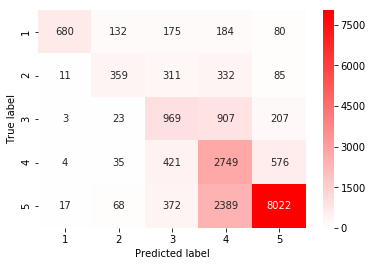

In [96]:
# Transform into a classification problem by rounding predictions
print('Macro F1: {:.2f}'.format(f1_score(y_val, preds.round(), average='macro')))
print('Weighted F1: {:.2f}'.format(f1_score(y_val, preds.round(), average='weighted')))
sns.heatmap(confusion_matrix(y_val, preds.round()), cmap='bwr', center=0, annot=True, fmt='.0f',
           xticklabels=range(1,6), yticklabels=range(1,6))
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

0.66 MSE in validation data is a surprising result. Given that the best MSE that could be achieved on the training phase was 0.99, the better perfomance on validation means that either the model needed more data to find better patterns, that there is still plenty of room to improve this model or even that validation data was too easy.

When translated into a classification problem (by rounding predicted scores), a weighted F1 (accounting for label imbalance) of 68% shows that results may be improved way further. Nevertheless, when one looks at the confusion matrix, most of the mistakes come from neighbour classes (e.g. it predicted a 4 but it was a 5), which are not a terrible mistake. Actually, if one thinks about it, humans don't tend to be 100% consistent when rating things (Daniel Kahneman is famous for theorizing on this), so even for the rater it could be easy to change a 5 for a 4. Therefore, even this simple over-optimistic model could be used in production and it will obtain ok results.

# Recommend to user
Finally, the trained model needs to be used to recommed new products to a given user. To do so, it is necessary to compute the expected score and sort the results.

In [148]:
def recommend(user=None, n=10, data=traintest, user_cols=user_cols,
              product_cols=product_cols, prod_features=prod_features,
              features=best_features, model=rf):
    
    if user is None:
        user = random.choice(test.UserId.unique())
        
    # Assemble dataset for prediction
    mask = data.UserId == user
    user_features = data[mask][user_cols].mean()
    
    included_products = data[mask].ProductId.unique()
    mask = data.ProductId.apply(lambda x: x not in included_products)
    products = data[mask][product_cols]
    
    products = products.merge(prod_features, left_on='ProductId', right_index=True, how='left')
    for i in user_features.iloc[1:].index:
        products[i] = user_features[i]
    
    # Predict and sort results
    preds = model.predict(products[features].fillna(0))
    recommended = data[mask][['ProductId']]
    recommended['PredScore'] = preds
    recommended.drop_duplicates(inplace=True)
    recommended = recommended.sort_values('PredScore', ascending=False).iloc[:n]
        
    print('{} recommended products for User {} with scores:'.format(n, user))
    print(recommended.to_string(index=False))
    
    return recommended

In [149]:
# Choose a random user and recommend him/her 10 products
_ = recommend()

10 recommended products for User 13619 with scores:
ProductId  PredScore
    59941        5.0
    31091        5.0
    52016        5.0
    60025        5.0
    29888        5.0
    12851        5.0
    13159        5.0
    36810        5.0
    19900        5.0
    69096        5.0


In [151]:
# Recommend 15 products to user 127
_ = recommend(127, 15)

15 recommended products for User 127 with scores:
ProductId  PredScore
    34023   3.117628
     2273   3.059578
    45099   3.047742
     3663   3.043650
    18090   2.987810
    26765   2.982199
    18090   2.980657
    41583   2.971789
    55586   2.967789
    41583   2.961824
    55586   2.957824
    56536   2.944563
    46244   2.939315
    29789   2.922852
    42915   2.920367
